# Drivers Drowsiness Detection

### Presentation of used case

*Objective:*

The primary objective of this project is to design and implement a robust system for real-time detection of driver drowsiness. Leveraging advanced machine learning algorithms and computer vision techniques, the system aims to accurately assess the level of drowsiness by analyzing pertinent indicators, including facial expressions and eye movements.

#### Key Components:
*Machine Learning Algorithms:*
- Implementation of sophisticated machine learning algorithms to process and analyze facial features, eye movements, and other relevant indicators.
- Utilization of deep learning techniques to extract intricate patterns and relationships from the input data, enabling the model to make accurate predictions.

*Computer Vision Techniques:*
- Integration of computer vision methods to extract and interpret visual cues from the driver's face, such as facial expressions and eye behavior.
- Deployment of image processing techniques to enhance the system's ability to recognize subtle signs of drowsiness.

### Functionalities:

*Real-time Monitoring:*
- Continuous monitoring of the driver's state in real-time, ensuring prompt detection of any signs of drowsiness during the course of driving.

*Alert Mechanism:*
- Implementation of a reliable alert mechanism that notifies the driver upon detection of drowsiness.
- Customization of alerts to ensure they are timely, non-intrusive, and effectively mitigate the risk of accidents associated with driver fatigue.

### Dataset description
The dataset to be used for this project is the [FL3D Dataset](https://www.kaggle.com/datasets/matjazmuc/frame-level-driver-drowsiness-detection-fl3d) which can be found on Kaggle.
FL3D was constructed using the NITYMED dataset (Night-Time Yawning-Microsleep-Eyeblink-driver Distraction. NITYMED consists of 130 videos displaying drivers in real cars, moving under nighttime conditions. FL3D takes frames from NITYMED and labels each frame with one of the following three labels: [alert, microsleep. yawning].
FL3D dataset consists of 53331 images. The validation and test set include 3 females and 2 males, among which the 2 females and 1 male are completely new drivers, not present in the training set.

### Model architecture

In the pursuit of an effective drowsiness detection system, two distinct models have been meticulously implemented to address the intricacies of the task at hand, differentiating between a baseline and an advanced comparison model aimed at achieving improved performance.

1. *Baseline Model: Custom Convolutional Neural Network (CNN)*
- The architecture is crafted to capture intricate patterns and features from facial expressions and eye movements, enabling the model to discern subtle signs of drowsiness.

2. *Advanced Model: Residual Neural Network (ResNet)*
- The advanced model utilizes a ResNet architecture, known for its deep and residual connections that facilitate the training of deeper neural networks.
- ResNet's skip connections address the vanishing gradient problem, enhancing the model's ability to capture hierarchical features and improving overall performance.

### Performance Evaluation
In assessing the efficacy of these models, the primary focus is placed on the *Recall metric*, a pivotal element in the confusion matrix. This deliberate choice stems from the fundamental premise that Recall plays a crucial role in minimizing instances where the model fails to detect actual drowsy states.
Rationale:
- Prioritizing Recall aligns with the paramount objective of the drowsiness detection system — minimizing the risk of missing genuine instances of driver drowsiness.
- False negatives, where the system fails to identify drowsiness, pose a higher risk in this application, justifying the emphasis on Recall as a critical evaluation metric.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, GlobalAveragePooling2D, Input,
                                     MaxPooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
from keras.models import load_model

## Custom Model

### Importing train data

In [6]:
file_path_train = './classification_frames/annotations_train.json'
with open(file_path_train, 'r') as file:
    data = json.load(file)

type(data)

dict

In [7]:
## Adding a column for file paths

rows = []
for image_path, annotations in data.items():
    row = annotations  
    row['image_path'] = image_path 
    rows.append(row)

In [8]:
df = pd.DataFrame(rows)

In [5]:
df.head()

,driver_state,landmarks,image_path
0,alert,"[[49, 122], [154, 127], [88, 183], [54, 241], ...",./classification_frames/P1043127_720/frame461.jpg
1,alert,"[[47, 122], [146, 125], [81, 175], [50, 238], ...",./classification_frames/P1043127_720/frame226.jpg
2,alert,"[[64, 127], [172, 139], [114, 197], [61, 254],...",./classification_frames/P1043127_720/frame336.jpg
3,alert,"[[31, 115], [119, 101], [48, 143], [37, 217], ...",./classification_frames/P1043127_720/frame428.jpg
4,alert,"[[89, 126], [190, 148], [145, 193], [77, 241],...",./classification_frames/P1043127_720/frame68.jpg


In [130]:
## Checking Label Imbalance
df['driver_state'].value_counts()

driver_state
alert         35483
microsleep     8074
yawning        4770
Name: count, dtype: int64

In [7]:
## Plot function for image

def plot_landmarks(image_path, landmarks):
    # Load the image
    image = Image.open(image_path)
    image_array = np.array(image)
    if image_array.dtype != np.uint8:
        image_array = (image_array * 255).astype(np.uint8)
    plt.imshow(image_array)
    plt.axis('off')
    for x, y in landmarks:
        plt.plot(x, y, 'ro') 


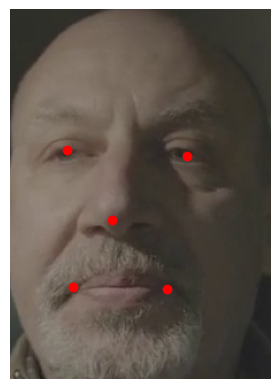

In [8]:
image_path = './classification_frames/P1043127_720/frame461.jpg' 
landmarks = [[49, 122], [154, 127], [88, 183], [54, 241], [136, 243]]
plot_landmarks(image_path, landmarks)

### Creat Balanced dataset with 15000 images

In [9]:
limited_df = df.groupby('driver_state').head(5000)

In [10]:
limited_df.driver_state.value_counts()

driver_state
alert         5000
microsleep    5000
yawning       4770
Name: count, dtype: int64

In [11]:
limited_df.head()

,driver_state,landmarks,image_path
0,alert,"[[49, 122], [154, 127], [88, 183], [54, 241], ...",./classification_frames/P1043127_720/frame461.jpg
1,alert,"[[47, 122], [146, 125], [81, 175], [50, 238], ...",./classification_frames/P1043127_720/frame226.jpg
2,alert,"[[64, 127], [172, 139], [114, 197], [61, 254],...",./classification_frames/P1043127_720/frame336.jpg
3,alert,"[[31, 115], [119, 101], [48, 143], [37, 217], ...",./classification_frames/P1043127_720/frame428.jpg
4,alert,"[[89, 126], [190, 148], [145, 193], [77, 241],...",./classification_frames/P1043127_720/frame68.jpg


In [12]:
## Image size to be used
image_size = (224,224)

In [4]:
## Image preprocessing function

def preprocess_image(image_path, target_size=image_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = img.astype('float32') 
    img = img / 255.0 # Normalize to [0, 1]
    return img



In [41]:
## Preprocessing images from the filepaths in the df

images = np.array([preprocess_image(path) for path in tqdm(limited_df['image_path'])])



  0%|          | 0/14770 [00:00<?, ?it/s]

  0%|          | 12/14770 [00:00<02:03, 119.38it/s]

  0%|          | 24/14770 [00:00<02:06, 116.87it/s]

  0%|          | 36/14770 [00:00<02:10, 112.91it/s]

  0%|          | 49/14770 [00:00<02:05, 117.35it/s]

  0%|          | 61/14770 [00:00<02:05, 117.33it/s]

  0%|          | 73/14770 [00:00<02:04, 118.11it/s]

  1%|          | 85/14770 [00:00<02:09, 113.47it/s]

  1%|          | 97/14770 [00:00<02:11, 111.22it/s]

  1%|          | 109/14770 [00:00<02:25, 100.95it/s]

  1%|          | 120/14770 [00:01<02:30, 97.39it/s] 

  1%|          | 130/14770 [00:01<02:33, 95.40it/s]

  1%|          | 142/14770 [00:01<02:24, 101.37it/s]

  1%|          | 155/14770 [00:01<02:15, 107.92it/s]

  1%|          | 167/14770 [00:01<02:12, 110.50it/s]

  1%|          | 179/14770 [00:01<02:13, 109.09it/s]

  1%|▏         | 190/14770 [00:01<02:14, 108.59it/s]

  1%|▏         | 201/14770 [00:01<02:13, 108.86it/s]

  1%|▏         | 212/14770 [00:01<02:15, 107.7

In [19]:
## Encoding the labels 

labels = np.array(limited_df['driver_state'])
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

### Data Splitting

In [114]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.25, random_state=42, stratify=labels)

### Model Building and Training

In [115]:
# Building our own CNN

model = tf.keras.models.Sequential()

# The first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D())

# The second convolution
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())

# The third convolution
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())

# The fourth convolution
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Dropout(0.3))
# Flattening the results to feed into a DNN
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))

model.add(Dense(3, activation='softmax'))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(learning_rate = 0.00015))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 64)       

- Learning rate was adjusted based on performance and training multiple times
- The number of convolution layers were selected based on multiple trials to get the optimal performance.

In [116]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 128)

Epoch 1/10
87/87 [==============================] - 123s 1s/step - loss: 0.2155 - accuracy: 0.9199 - val_loss: 0.8031 - val_accuracy: 0.9299
Epoch 2/10
87/87 [==============================] - 87s 999ms/step - loss: 0.0602 - accuracy: 0.9809 - val_loss: 0.6625 - val_accuracy: 0.9867
Epoch 3/10
87/87 [==============================] - 85s 976ms/step - loss: 0.0371 - accuracy: 0.9882 - val_loss: 0.4488 - val_accuracy: 0.9859
Epoch 4/10
87/87 [==============================] - 93s 1s/step - loss: 0.0296 - accuracy: 0.9904 - val_loss: 0.3104 - val_accuracy: 0.9732
Epoch 5/10
87/87 [==============================] - 91s 1s/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.1241 - val_accuracy: 0.9892
Epoch 6/10
87/87 [==============================] - 89s 1s/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.0477 - val_accuracy: 0.9900
Epoch 7/10
87/87 [==============================] - 86s 992ms/step - loss: 0.0174 - accuracy: 0.9943 - val_loss: 0.0398 - val_accuracy: 0.9905
Epoch 8/10

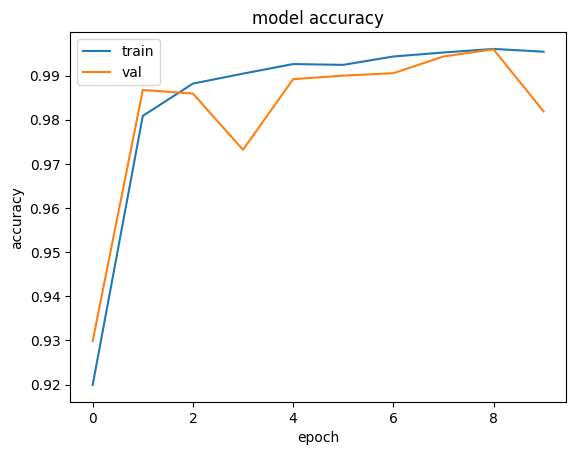

In [117]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

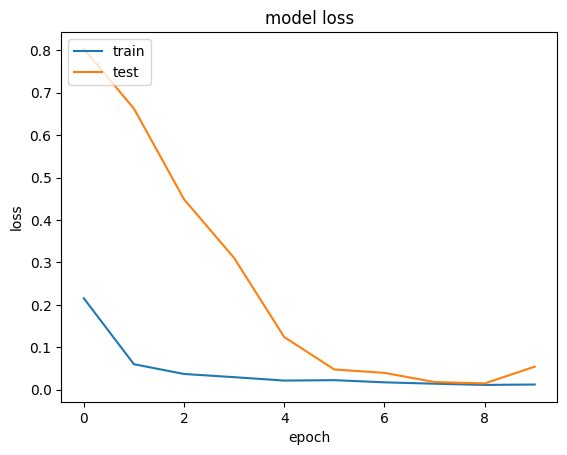

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [144]:
## Saving model
model.save('./saved_models/model.h5')

C:\Users\marja\conda\envs\myapi\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Testing

In [5]:
trained_model = load_model('./saved_models/model.h5')

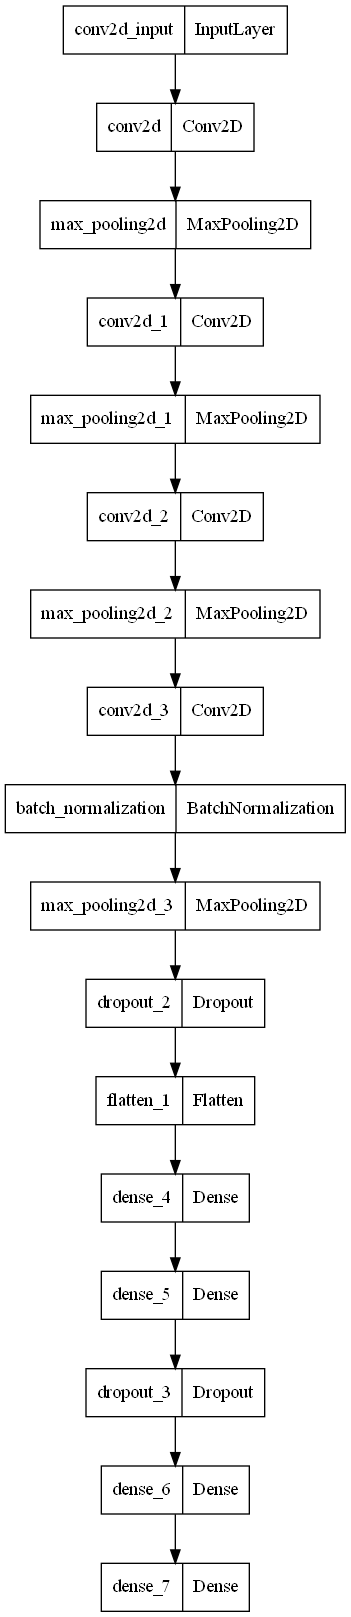

In [9]:
tf.keras.utils.plot_model(trained_model)

In [2]:
## Loading the test data

file_path_train = './classification_frames/annotations_test.json'
with open(file_path_train, 'r') as file:
    data = json.load(file)

rows = []
for image_path, annotations in data.items():
    row = annotations  
    row['image_path'] = image_path 
    rows.append(row)

df_test = pd.DataFrame(rows)

df_test_copy = df_test[:500].copy()

In [3]:
label_mapping = {'alert': 0, 'microsleep': 1, 'yawning': 2} 

In [4]:
## Encoding the test labels to integers

labels_test = df_test_copy['driver_state'].map(label_mapping)

In [9]:
## Test set array

img_test_arr_model1 = np.array([preprocess_image(path) for path in tqdm(df_test_copy['image_path'])])

100%|██████████| 500/500 [00:03<00:00, 133.10it/s]


In [37]:
## Performing Predictions

predictions = trained_model.predict(img_test_arr_model1)
predicted_classes = np.argmax(predictions, axis=1)

16/16 [==============================] - 2s 124ms/step


### Model Evaluation

In [38]:
# Calculating accuracy
accuracy = accuracy_score(labels_test, predicted_classes)

# Calculating precision and recall
precision = precision_score(labels_test, predicted_classes, average='macro')
recall = recall_score(labels_test, predicted_classes, average='macro')

# Confusion matrix
conf_matrix = confusion_matrix(labels_test, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.86
Precision: 0.7846086148329098
Recall: 0.8896639090179593


In [19]:
conf_mat_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

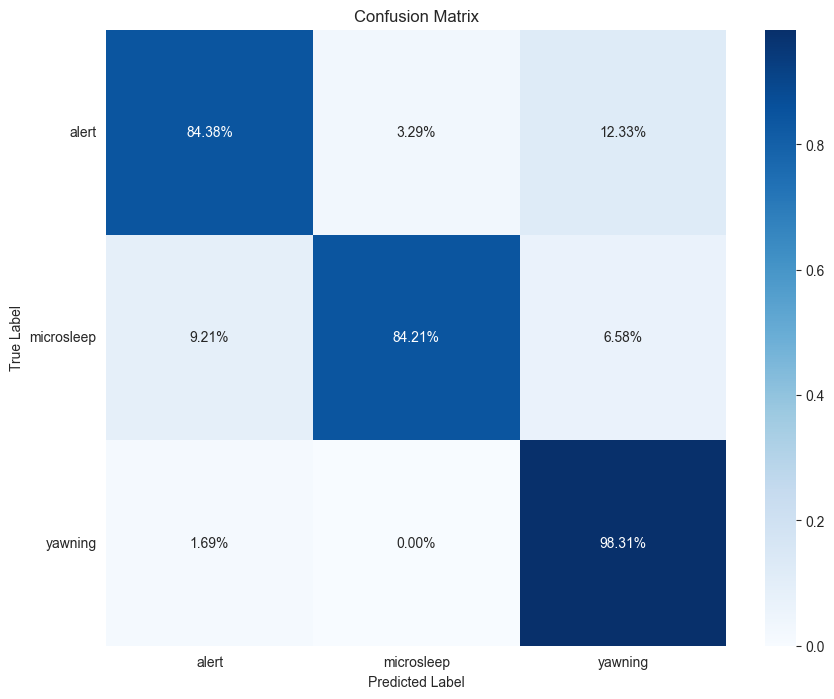

In [20]:
plt.figure(figsize=(10, 8))

sns.heatmap(conf_mat_percentage, annot=True, fmt=".2%", cmap="Blues")

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

class_names = ['alert', 'microsleep', 'yawning'] 
plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

plt.show()

### Result:
From the metrics, it can be observed that the Recall metric (which is crucial for our use case) has a percentage 89%, which is very good.

## Using pre-trained model: RESNET50

### Image Preprocessing

In [13]:
## Preprocessing function for image
def get_image(image_path, target_size=image_size):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = img.astype('float32') 
    return img

In [14]:
## Preparing train array
X = np.array([get_image(path) for path in tqdm(limited_df['image_path'])])

100%|██████████| 14770/14770 [00:43<00:00, 336.44it/s]


In [15]:
## Function to extract features using resnet preprocessor function
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [16]:
resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input

In [17]:
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

462/462 [==============================] - 585s 1s/step
Feature maps shape: (14770, 2048)


In [20]:
## Splitting into train and val data
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(resnet_features, labels, test_size= 0.25, random_state= 42)

In [21]:
X_train_1 = X_train_1 / 255.0
X_val_1 = X_val_1 / 255.0

In [22]:
## Fully connected layers after the pretrained model

model_res = Sequential()
model_res.add(Input(X_train_1.shape[1]))
model_res.add(Flatten())
model_res.add(Dense(512, activation='relu'))
model_res.add(Dense(256, activation='relu'))
model_res.add(Dense(128, activation='relu'))
model_res.add(Dropout(0.3))
model_res.add(Dense(64, activation='relu'))

model_res.add(Dense(3, activation='softmax'))
model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 3)                 1

In [24]:
history = model_res.fit(X_train_1, y_train_1, validation_data = (X_val_1, y_val_1), epochs = 10, batch_size = 64)

Epoch 1/10
174/174 [==============================] - 5s 15ms/step - loss: 0.3080 - accuracy: 0.8997 - val_loss: 0.1613 - val_accuracy: 0.9361
Epoch 2/10
174/174 [==============================] - 2s 12ms/step - loss: 0.0598 - accuracy: 0.9794 - val_loss: 0.0521 - val_accuracy: 0.9851
Epoch 3/10
174/174 [==============================] - 2s 12ms/step - loss: 0.0375 - accuracy: 0.9870 - val_loss: 0.0625 - val_accuracy: 0.9797
Epoch 4/10
174/174 [==============================] - 2s 12ms/step - loss: 0.0292 - accuracy: 0.9915 - val_loss: 0.0358 - val_accuracy: 0.9892
Epoch 5/10
174/174 [==============================] - 2s 12ms/step - loss: 0.0260 - accuracy: 0.9910 - val_loss: 0.0672 - val_accuracy: 0.9770
Epoch 6/10
174/174 [==============================] - 2s 12ms/step - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.0787 - val_accuracy: 0.9743
Epoch 7/10
174/174 [==============================] - 2s 12ms/step - loss: 0.0250 - accuracy: 0.9919 - val_loss: 0.1027 - val_accuracy: 0.9694

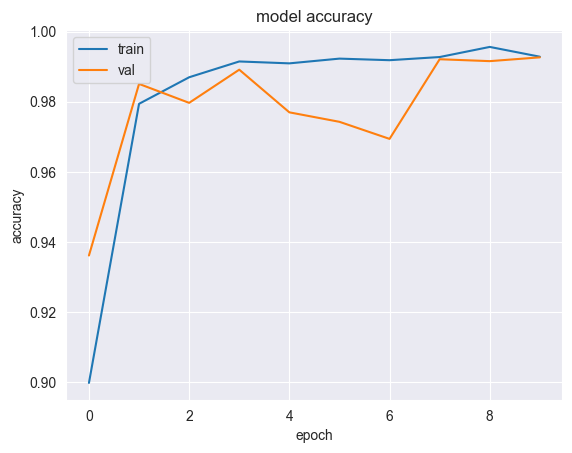

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

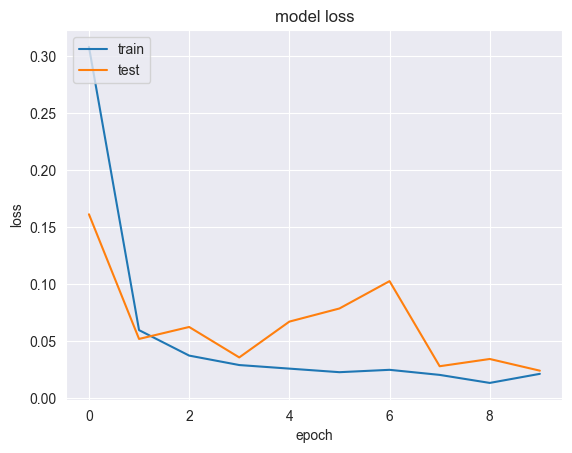

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
model_res.save('./saved_models/model_res.h5')

C:\Users\marja\conda\envs\myapi\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
trained_model_res = load_model('./saved_models/model_res.h5')

### Model testing and Evaluation

In [29]:
## Taking 15 images

df_test_limited = df_test.groupby('driver_state').head(5)

In [30]:
df_test_limited['driver_state'].value_counts()

driver_state
yawning       5
alert         5
microsleep    5
Name: count, dtype: int64

In [72]:
img_test_files = df_test_limited['image_path'].to_list()

1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 4s 4s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 3s 3s/step
Feature maps shape: (1, 2048)
1/1 [==============================] - 5

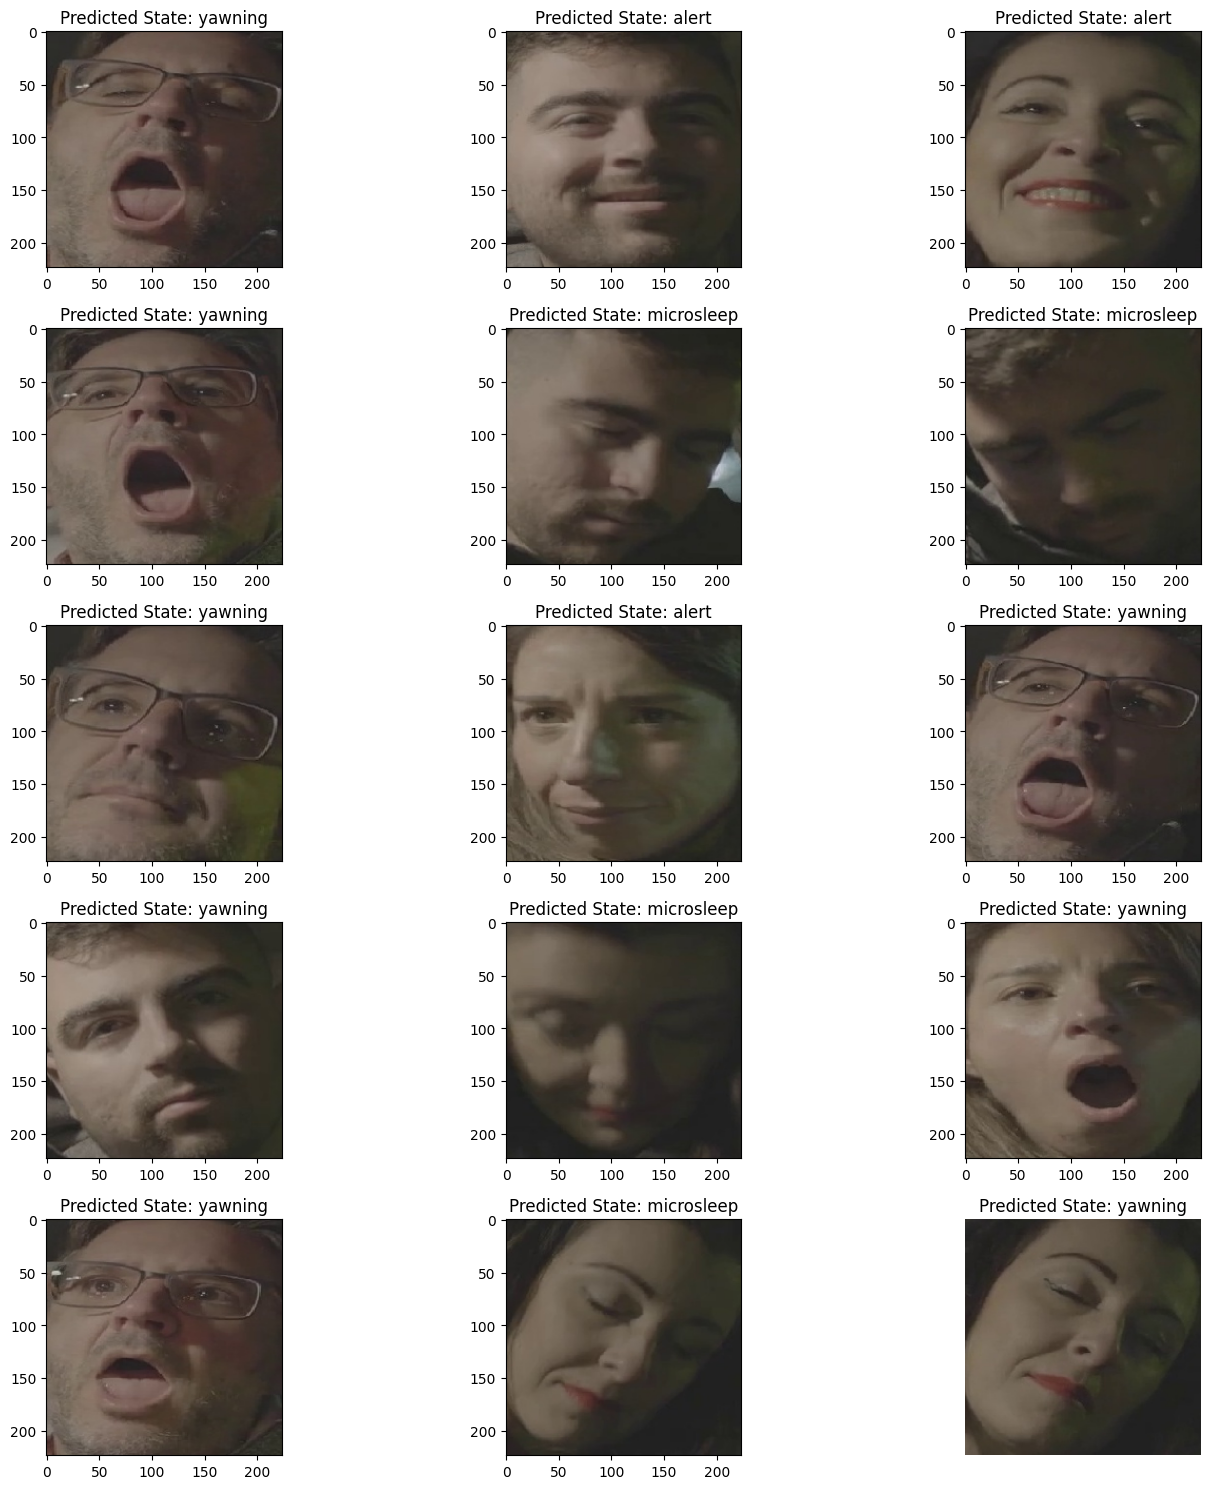

In [137]:
num_cols = 3
num_rows = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, img in enumerate(img_test_files):
    file_name = img
    image_test = load_img(file_name, target_size=image_size)
    img_array = np.array(image_test)
    img_array = img_array.reshape((1, 224, 224, 3))
    img_array = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), img_array)
    state_index = model_res.predict(img_array).argmax(axis=-1)
    state_label = [
        label for label, index in label_mapping.items() if index == state_index
    ][0]

    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image_test)
    axes[row, col].set_title(f"Predicted State: {state_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
## Image data preprocessing
img_test_arr = np.array([get_image(path) for path in tqdm(df_test_copy['image_path'])])

100%|██████████| 500/500 [00:02<00:00, 232.81it/s]


In [30]:
test_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), img_test_arr)

16/16 [==============================] - 22s 1s/step
Feature maps shape: (500, 2048)


In [32]:
predictions = trained_model_res.predict(test_features)
predicted_classes = np.argmax(predictions, axis=1)

16/16 [==============================] - 0s 4ms/step


In [33]:
# Calculating accuracy
accuracy = accuracy_score(labels_test, predicted_classes)

# Calculating precision and recall
precision = precision_score(labels_test, predicted_classes, average='macro')
recall = recall_score(labels_test, predicted_classes, average='macro')

# Confusion matrix
conf_matrix = confusion_matrix(labels_test, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.87
Precision: 0.7834749778057076
Recall: 0.9081210106762145


In [34]:
conf_mat_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

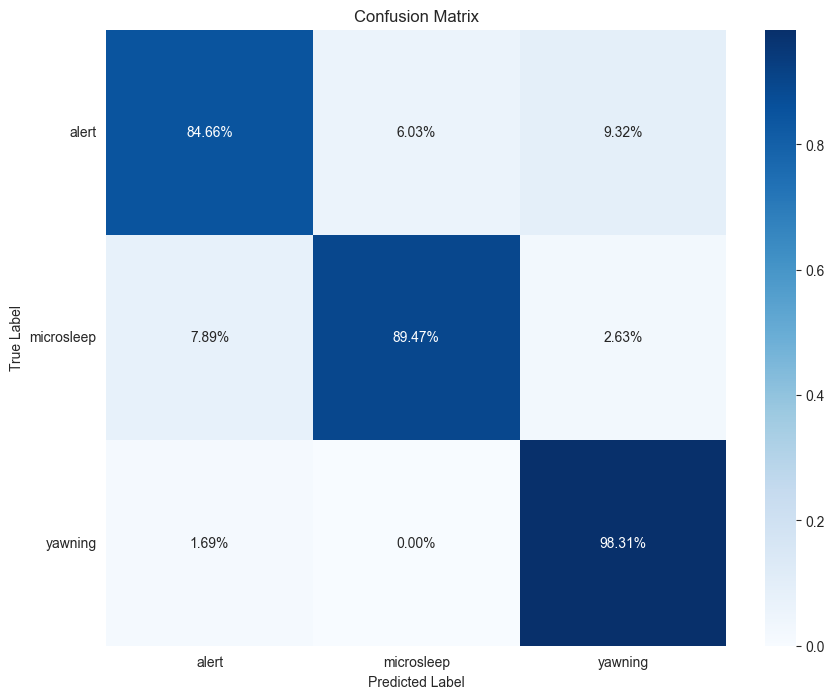

In [35]:
plt.figure(figsize=(10, 8))

sns.heatmap(conf_mat_percentage, annot=True, fmt=".2%", cmap="Blues")

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

class_names = ['alert', 'microsleep', 'yawning'] 
plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

plt.show()

### Result:
From the metrics, it can be observed that this model is also providing us with a veru good recall score, and it can be further fine-tuned to perform even better. Also the preprocess function is quite effective and the training requires very less time than the custom made CNN

### Comparison:
For both of the models, we can observe that the recall score is almost the same, but for the other metrics, the Resnet50 performs better. Also, since the custom CNN is only trained on the drivers dataset, it performs well in our use case. But to have a more generalised approach, we can optimize the Resnet50 by taking more images in the datset, since the process of feature extraction and training is alot less than for the custom CNN. 

Recall - CNN: 89% 
Recall 90.8% 



### References
- [Driver Drowsiness Facial Image Analysis](https://medium.com/@jordan.ehlinger/driver-drowsiness-facial-image-analysis-7d0171ed52a3)
- [Eyes-Open-Closed-Image-Classification](https://github.com/jordanehli/Eyes-Open-Closed-Image-Classification)
- [Deep Residual Networks (ResNet, ResNet50) – 2024 Guide](https://viso.ai/deep-learning/resnet-residual-neural-network/)
- https://github.com/pratvedulla/AML-project